In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import keras
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, RNN, LSTM, Flatten, SpatialDropout1D, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import warnings
warnings.simplefilter(action='ignore')
#using GPU to accelerate training
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


In [0]:
from google.colab import files

uploaded = files.upload()

In [0]:
# data loading
import io
path = "/home/rauls/conala-corpus"
test_path = "conala-test.json"
train_path = "conala-train.json"
mined_path = "conala-mined.jsonl"
#test = pd.read_json(path+test_path)
#train = pd.read_json(path+train_path)
mined = pd.read_json("conala-mined.jsonl", lines=True)
#mined = pd.read_csv("/content/mined_as_csv (1).csv")
#mined = pd.read_json("conala-mined(1).jsonl", lines=True)
mined = mined.sample(400000)

In [0]:
from matplotlib import pyplot as plt
mined['prob'] = mined['prob'].apply(lambda x: np.log(x))
mined['prob'] = mined['prob'] + 10
mined['prob'] = mined['prob'].apply(lambda x: x/10)
mined['prob'].plot()

# train test split
X = mined[['intent', 'snippet']]
y = mined['prob'].as_matrix()
print(mined['prob'].mean())

0.6627366429177975


OverflowError: ignored

<Figure size 432x288 with 1 Axes>

In [0]:
mined.info()
del mined

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 174014 to 141284
Data columns (total 6 columns):
id                       400000 non-null int64
intent                   400000 non-null object
parent_answer_post_id    400000 non-null int64
prob                     400000 non-null float64
question_id              400000 non-null int64
snippet                  400000 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 21.4+ MB


In [0]:
# data cleanup to save memory
# usually you would want to clean up special characters like "'" or ";" but since we are dealing with code here....
X['intent'] = X['intent'].apply(lambda x: x.lower())
X['intent'] = X['intent'].apply(lambda x: re.sub(pattern='[^a-z0-9]', string=x, repl=' '))

In [0]:
# concatenate snippet and intent
# the network is powerful enough and gets enough data
# to learn that our border word marks a border
X['intent'] = X['intent'] + ' STOP ' + X['snippet']

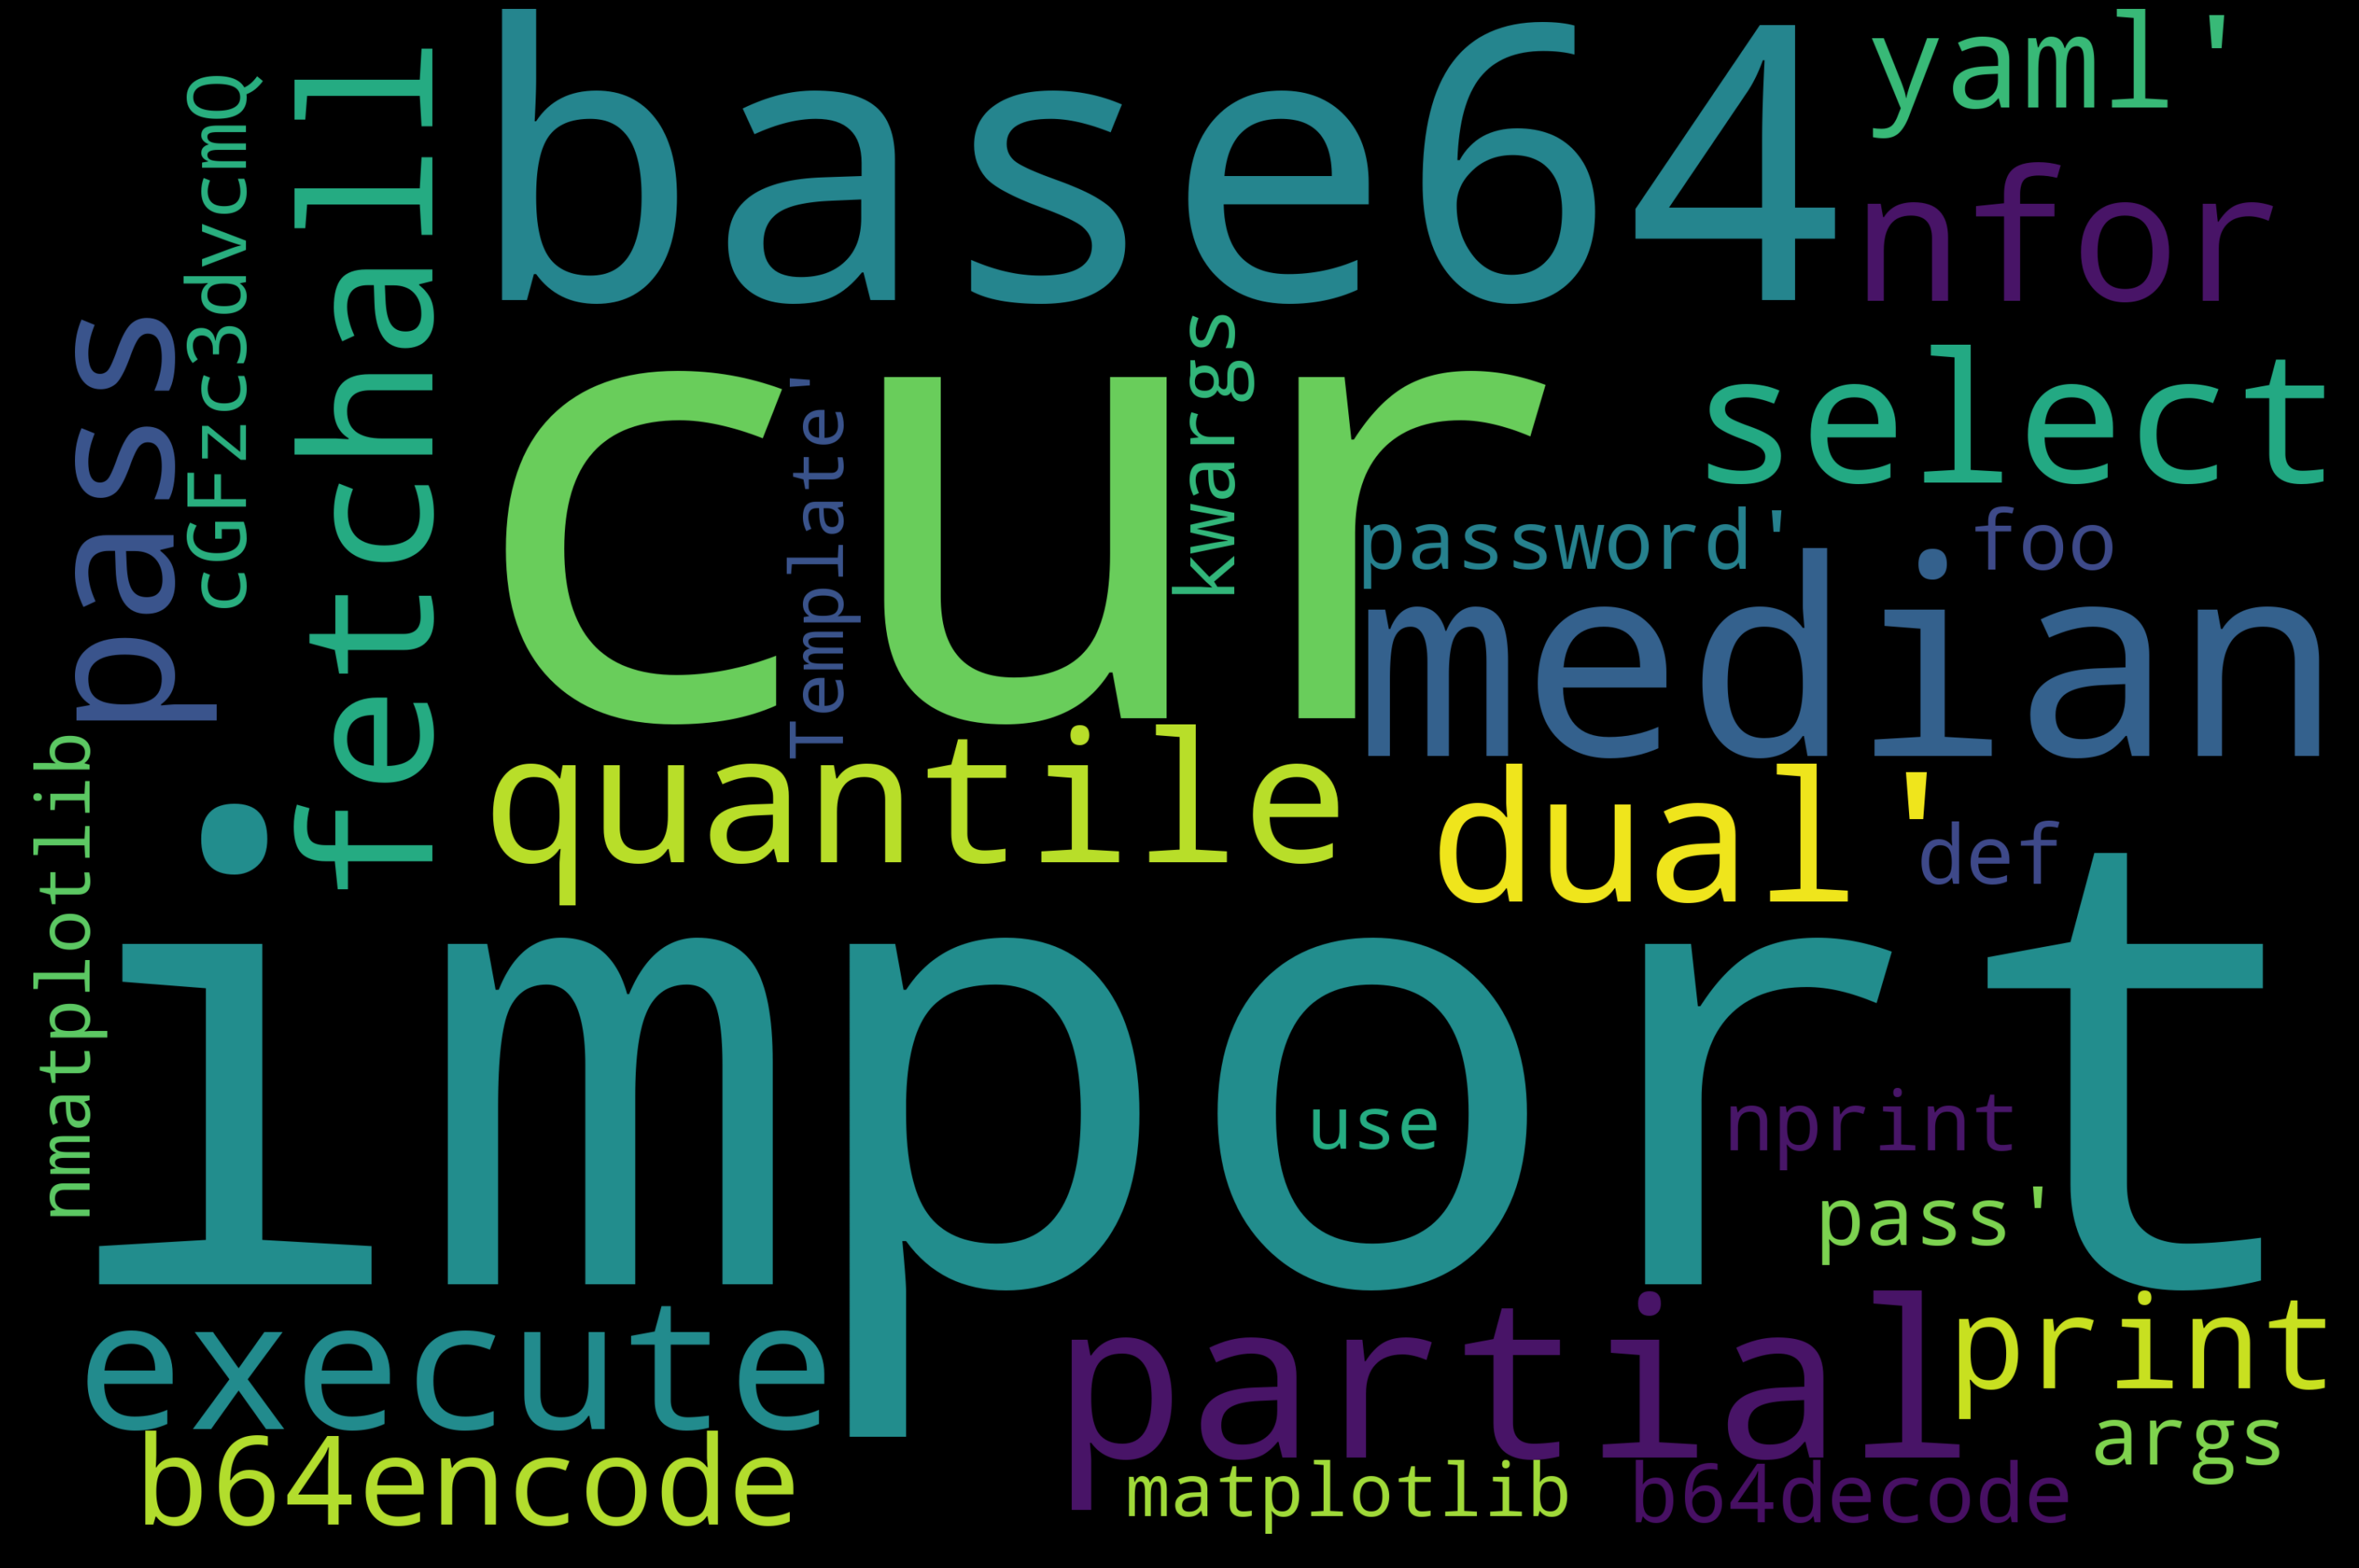

In [0]:
# here we are creating a WordCloud for analytical puroposes
# it functions like a more visual histogram
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = X['snippet'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = None).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
X = X['intent']

In [0]:
X = X.astype(str)

In [0]:
# we tokenize the text and pad the tokens
MAX_NB_WORDS = 950
MAX_SEQUENCE_LENGTH  = 195
EMBEDDING_DIM = 750
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
import pickle
# saving
with open('tokenizer.pk', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=1)

In [0]:
# this is a rather simple LSTM
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(300))
model.add(Dropout(0.2))
#model.add(Dense(500))
# model.add(LSTM(256, dropout=0.2, return_sequences=True))
# model.add(LSTM(256, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae', 'mse'])

epochs = 15
batch_size = 128

history = model.fit(X, y, epochs=epochs,verbose=1, batch_size=batch_size, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=9, min_delta=0.0001)])

W0811 11:15:04.588605 140020912813952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 11:15:04.591367 140020912813952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 11:15:04.595483 140020912813952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 11:15:04.616940 140020912813952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 11:15:04.625738 

Train on 320000 samples, validate on 80000 samples
Epoch 1/15
320000/320000 [==============================] - 1680s 5ms/step - loss: 0.0811 - mean_absolute_error: 0.0811 - mean_squared_error: 0.0112 - val_loss: 0.0747 - val_mean_absolute_error: 0.0747 - val_mean_squared_error: 0.0095
Epoch 2/15
320000/320000 [==============================] - 1671s 5ms/step - loss: 0.0732 - mean_absolute_error: 0.0732 - mean_squared_error: 0.0089 - val_loss: 0.0695 - val_mean_absolute_error: 0.0695 - val_mean_squared_error: 0.0081
Epoch 3/15
320000/320000 [==============================] - 1682s 5ms/step - loss: 0.0698 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0082 - val_loss: 0.0677 - val_mean_absolute_error: 0.0677 - val_mean_squared_error: 0.0078
Epoch 4/15
320000/320000 [==============================] - 1677s 5ms/step - loss: 0.0674 - mean_absolute_error: 0.0674 - mean_squared_error: 0.0077 - val_loss: 0.0667 - val_mean_absolute_error: 0.0667 - val_mean_squared_error: 0.0076
Epoch 5/1

In [0]:
from scipy import stats

xi = np.arange(0, len(history.history['val_loss']))
y = history.history['val_loss']
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

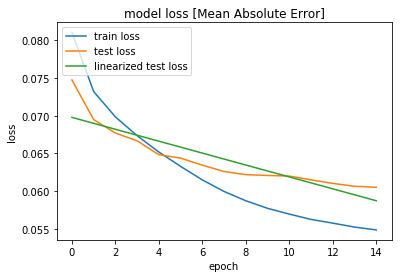

In [0]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(line)
plt.title('model loss [Mean Absolute Error]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'test loss', 'linearized test loss'], loc='upper left')
plt.savefig('loss.pdf')
plt.show()

In [0]:
from keras.models import load_model
model.save('lstm.h5')
model.save_weights('model.h5')
model_json = model.to_json()
with open('model.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()